# Preprocessing Cheat Sheet
```PSMCV-2.2022-2023.1```

Authors: 
- Robbert van der Mijn, w.r.van.der.mijn@rug.nl, 2022
- Mark Span, m.m.span@rug.nl, 2024

This notebook serves as a comprehensive guide for preprocessing scripts commonly used in data analysis. The scripts provided here aim to facilitate various preprocessing tasks, ensuring data is clean and ready for analysis.


## Modules and Packages

This section outlines the necessary modules and packages required for the preprocessing tasks. Ensure that all these packages are installed in your environment.

- **eyelinkparser**: A package for parsing EyeLink data files.
- **datamatrix**: A library for working with data matrices, providing functionality for data manipulation and analysis.
- **fastnumbers**: A module for fast and safe conversion of strings to numbers.
- **numpy**: A fundamental package for numerical computations in Python.
- **scipy**: A library used for scientific and technical computing.
- **prettytable**: A module to create ASCII tables in Python.
- **openpyxl**: A library to read/write Excel 2010 xlsx/xlsm/xltx/xltm files.
- **json-tricks**: A library for handling JSON files with additional features.
- **tomlkit**: A library for TOML file parsing.
- **psutil**: A cross-platform library for accessing system details and process utilities.


In [1]:
# Install the eyelinkparser package which is used for parsing EyeLink data files.
!pip install eyelinkparser

## Data Loading

This section covers the steps required to load the data into the notebook.

In [2]:
# Datamatrix is also from Sebastiaan. You need a conveinient method to manage all your data...

from datamatrix import (
    plot,
    operations as ops,
    series as srs,
    functional as fnc,
    SeriesColumn,
)
from eyelinkparser import parse, defaulttraceprocessor
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.font_manager

# This is a really helpfull library if you want to combine the use of R and Python.
%load_ext rpy2.ipython

## Declaring a function

The eyelinkparser needs info from you on what your trials look like. Therefore you need to write a function that reads in your trials and define its structure in there. Like this:

In [3]:
def my_preprocessor():
    
    dm = parse(
        traceprocessor = defaulttraceprocessor(
          blinkreconstruct = True,
          mode= 'advanced',
          downsample = None
        )
    )
    
    # define the max depth manually: baseline, problem, fixation, response and feedback
    MAX_DEPTH = 1500 + 800 + 2500 + 2000 

    # get the current max depth, we'll be cutting it off later
    max_depth = dm.ptrace_baseline.depth + dm.ptrace_problem.depth + dm.ptrace_fixation.depth + dm.ptrace_response.depth + dm.ptrace_feedback.depth

    # Create new series column that will hold our new pupil trace
    dm.pupil = SeriesColumn(depth = max_depth)

    # For each trial, trim pupil traces based on the nan values in the time trace (there are more elegant solutions I'm sure)
    for i, row in enumerate(dm):
        ptrace_baseline = row.ptrace_baseline[~np.isnan(row.ttrace_baseline)]
        ptrace_problem = row.ptrace_problem[~np.isnan(row.ttrace_problem)]
        ptrace_fixation = row.ptrace_fixation[~np.isnan(row.ttrace_fixation)]
        ptrace_response = row.ptrace_response[~np.isnan(row.ttrace_response)]
        ptrace_feedback = row.ptrace_feedback[~np.isnan(row.ttrace_feedback)]
        
        # Concatenate and pad so they're all the same depth
        pupil = np.concatenate((ptrace_baseline, ptrace_problem, ptrace_fixation, ptrace_response, ptrace_feedback))
        pupil = np.pad(pupil, (0, max_depth - len(pupil)), "constant", constant_values = np.nan)
        
        # Write this trial to the original dm
        dm.pupil[i] = pupil
        
    # Trim the original dm to our manual depth (the feedback phase of some of the really long trials will be cut off)
    dm.pupil.depth = MAX_DEPTH
    # and return only the data we want to analyse. 
    dm = dm[("subject_nr", "pupil", "count_trial_sequence", "correct", "difficulty", "practice")]
    
    return dm


............................................................................................................................................................................................................................

Note that nothing happened yet. We only defined what has to be done to read in the files.

The actual action, the reading, is done by *calling* our function:

In [ ]:
dm = my_preprocessor()

## Data Cleaning

In this example, the data cleaning is automated. This is not always possible, and therefore this placeholder title is inserted. If needed: Clean your data here.

## Data Visualization

This section provides methods for visualizing the data to gain insights.

### Saving plots as pngs

We use MatPlotLib for plotting here. There is sometimes an issue with the fonts matplotlib defaults to. Hopefully this is a fix for that. If you have many warnings about fonts, please let me know...

In [5]:
import matplotlib as mpl
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "DejaVu Sans"

Plot the mean pupilsize during the trials:

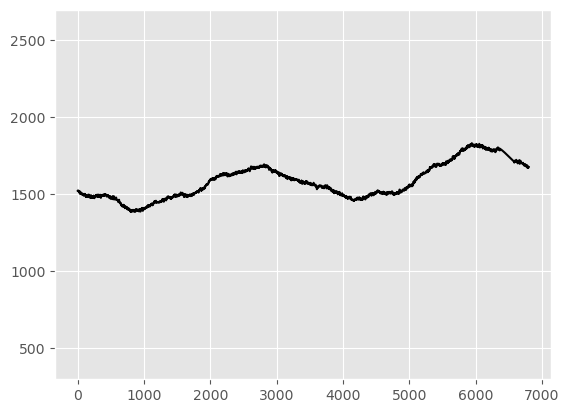

In [6]:
plt.plot(dm.pupil[0], color = "black")
plt.ylim(300, 2700)
plt.savefig('single_trial.png', bbox_inches='tight')

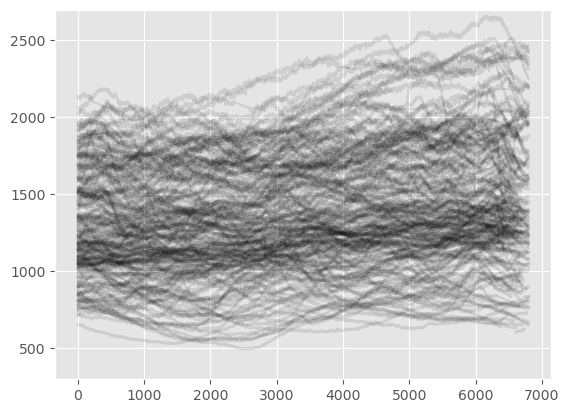

In [7]:
for row in dm:    
    plt.plot(row.pupil, alpha = .1, color = "black")
plt.ylim(300, 2700)
plt.savefig('all_trials.png', bbox_inches='tight')